## importing libs

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## set up the movie data

In [181]:
df = pd.read_csv("../Model/updated_movies.csv", engine="python")

df.head(5)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [182]:
df=df.drop(columns="adult")

In [183]:
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15543,94196,Zarafa,6.838,101,Released,2012-01-25,12197574,78,/wu1ZfK910bxCUtyne1bL1s9lOLj.jpg,10750000,...,Zarafa,Inspired by the true story of the first giraff...,7.685,/gsTt2bxvffCIsRoZlXDqRGM01H9.jpg,NaN,"Family, Animation","France 3 Cinéma, Prima Linéa Productions, Chao...","Belgium, France",French,"giraffe, sudan, based on true story, orphan, 1..."
15544,352695,Joshy,5.569,101,Released,2016-08-12,0,93,NaN,0,...,Joshy,"After his engagement ends badly, Josh decides ...",5.185,/qccbXBSGXopEmDN9BoFeWV5EgDA.jpg,Wedding's off. Party's on.,"Drama, Comedy","American Zoetrope, Destro Films, Bow + Arrow E...",United States of America,English,"male friendship, loss, board game, hot tub, bo..."
15545,23928,Captain Horatio Hornblower,6.842,101,Released,1951-04-10,0,117,/79SaswBGk6lVbPgnGJQKC84NUyL.jpg,0,...,Captain Horatio Hornblower R.N.,Captain Horatio Hornblower leads his ship HMS ...,9.043,/oielnqLw4gVpaJDN6QTOapCqRXf.jpg,The sun never sets on his world of adventure.,"Adventure, War, History",Warner Bros. Pictures,United Kingdom,English,"captain, battle, napoleonic wars, sea battle"
15546,61564,The Bravados,6.416,101,Released,1958-06-25,0,98,/71W4e9BEHulPjU76JiYz2QsCc3U.jpg,0,...,The Bravados,Jim Douglass arrives in the small town of Rio ...,12.641,/qKWu7yUqG4QAY9FuIiBDLGjQWRm.jpg,A Powerful Western Tale of Revenge and Redemption,Western,20th Century Fox,United States of America,"English, Spanish",rape and revenge


In [184]:
df.shape

(15548, 23)

In [185]:
def categorize_release_date(date):
    year = int(date.split("-")[0])
    if year < 2000:
        return "old"
    elif 2000 <= year < 2015:
        return "recent"
    else:
        return "new"
df['release_date_categorized'] = df['release_date'].apply(categorize_release_date)
df['release_date'].value_counts()
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date_categorized
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",recent
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",recent
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",recent
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",recent
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",recent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15543,94196,Zarafa,6.838,101,Released,2012-01-25,12197574,78,/wu1ZfK910bxCUtyne1bL1s9lOLj.jpg,10750000,...,Inspired by the true story of the first giraff...,7.685,/gsTt2bxvffCIsRoZlXDqRGM01H9.jpg,NaN,"Family, Animation","France 3 Cinéma, Prima Linéa Productions, Chao...","Belgium, France",French,"giraffe, sudan, based on true story, orphan, 1...",recent
15544,352695,Joshy,5.569,101,Released,2016-08-12,0,93,NaN,0,...,"After his engagement ends badly, Josh decides ...",5.185,/qccbXBSGXopEmDN9BoFeWV5EgDA.jpg,Wedding's off. Party's on.,"Drama, Comedy","American Zoetrope, Destro Films, Bow + Arrow E...",United States of America,English,"male friendship, loss, board game, hot tub, bo...",new
15545,23928,Captain Horatio Hornblower,6.842,101,Released,1951-04-10,0,117,/79SaswBGk6lVbPgnGJQKC84NUyL.jpg,0,...,Captain Horatio Hornblower leads his ship HMS ...,9.043,/oielnqLw4gVpaJDN6QTOapCqRXf.jpg,The sun never sets on his world of adventure.,"Adventure, War, History",Warner Bros. Pictures,United Kingdom,English,"captain, battle, napoleonic wars, sea battle",old
15546,61564,The Bravados,6.416,101,Released,1958-06-25,0,98,/71W4e9BEHulPjU76JiYz2QsCc3U.jpg,0,...,Jim Douglass arrives in the small town of Rio ...,12.641,/qKWu7yUqG4QAY9FuIiBDLGjQWRm.jpg,A Powerful Western Tale of Revenge and Redemption,Western,20th Century Fox,United States of America,"English, Spanish",rape and revenge,old


In [186]:
df["poster_path"] = "https://image.tmdb.org/t/p/w500" + df["poster_path"]

In [187]:
print(df[df["title"] == "Interstellar"].iloc[0]["overview"])

The adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.


In [188]:
df.tagline

0                     Your mind is the scene of the crime.
1        Mankind was born on Earth. It was never meant ...
2                        Welcome to a world without rules.
3                              Enter the world of Pandora.
4                                  Some assembly required.
                               ...                        
15543                                                  NaN
15544                           Wedding's off. Party's on.
15545        The sun never sets on his world of adventure.
15546    A Powerful Western Tale of Revenge and Redemption
15547    King Arthur's Round Table will never be the same!
Name: tagline, Length: 15548, dtype: object

## EDA

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15548 entries, 0 to 15547
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        15548 non-null  int64  
 1   title                     15548 non-null  object 
 2   vote_average              15548 non-null  float64
 3   vote_count                15548 non-null  int64  
 4   status                    15548 non-null  object 
 5   release_date              15548 non-null  object 
 6   revenue                   15548 non-null  int64  
 7   runtime                   15548 non-null  int64  
 8   backdrop_path             15514 non-null  object 
 9   budget                    15548 non-null  int64  
 10  homepage                  5412 non-null   object 
 11  imdb_id                   15540 non-null  object 
 12  original_language         15548 non-null  object 
 13  original_title            15548 non-null  object 
 14  overvi

In [190]:
df.isnull().sum()

id                              0
title                           0
vote_average                    0
vote_count                      0
status                          0
release_date                    0
revenue                         0
runtime                         0
backdrop_path                  34
budget                          0
homepage                    10136
imdb_id                         8
original_language               0
original_title                  0
overview                        0
popularity                      0
poster_path                     0
tagline                      3483
genres                          0
production_companies          164
production_countries           33
spoken_languages                9
keywords                        0
release_date_categorized        0
dtype: int64

In [191]:
df["tagline"]=df["tagline"].fillna("")
df["spoken_languages"]=df["spoken_languages"].fillna("")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15548 entries, 0 to 15547
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        15548 non-null  int64  
 1   title                     15548 non-null  object 
 2   vote_average              15548 non-null  float64
 3   vote_count                15548 non-null  int64  
 4   status                    15548 non-null  object 
 5   release_date              15548 non-null  object 
 6   revenue                   15548 non-null  int64  
 7   runtime                   15548 non-null  int64  
 8   backdrop_path             15514 non-null  object 
 9   budget                    15548 non-null  int64  
 10  homepage                  5412 non-null   object 
 11  imdb_id                   15540 non-null  object 
 12  original_language         15548 non-null  object 
 13  original_title            15548 non-null  object 
 14  overvi

## Combining

In [192]:
df.loc[:, "Combined"] =df["genres"]+" "+df["overview"]+" "+df["title"]+df["original_language"]+df["tagline"]+df["spoken_languages"]+df["keywords"]+df["release_date_categorized"]
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date_categorized,Combined
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,83.952,https://image.tmdb.org/t/p/w500/oYuLEt3zVCKq57...,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",recent,"Action, Science Fiction, Adventure Cobb, a ski..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,140.241,https://image.tmdb.org/t/p/w500/gEU2QniE6E77NI...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",recent,"Adventure, Drama, Science Fiction The adventur..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,130.643,https://image.tmdb.org/t/p/w500/qJ2tW6WMUDux91...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",recent,"Drama, Action, Crime, Thriller Batman raises t..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,79.932,https://image.tmdb.org/t/p/w500/kyeqWdyUXW608q...,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",recent,"Action, Adventure, Fantasy, Science Fiction In..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,98.082,https://image.tmdb.org/t/p/w500/RYMX2wcKCBAr24...,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",recent,"Science Fiction, Action, Adventure When an une..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15543,94196,Zarafa,6.838,101,Released,2012-01-25,12197574,78,/wu1ZfK910bxCUtyne1bL1s9lOLj.jpg,10750000,...,7.685,https://image.tmdb.org/t/p/w500/gsTt2bxvffCIsR...,,"Family, Animation","France 3 Cinéma, Prima Linéa Productions, Chao...","Belgium, France",French,"giraffe, sudan, based on true story, orphan, 1...",recent,"Family, Animation Inspired by the true story o..."
15544,352695,Joshy,5.569,101,Released,2016-08-12,0,93,NaN,0,...,5.185,https://image.tmdb.org/t/p/w500/qccbXBSGXopEmD...,Wedding's off. Party's on.,"Drama, Comedy","American Zoetrope, Destro Films, Bow + Arrow E...",United States of America,English,"male friendship, loss, board game, hot tub, bo...",new,"Drama, Comedy After his engagement ends badly,..."
15545,23928,Captain Horatio Hornblower,6.842,101,Released,1951-04-10,0,117,/79SaswBGk6lVbPgnGJQKC84NUyL.jpg,0,...,9.043,https://image.tmdb.org/t/p/w500/oielnqLw4gVpaJ...,The sun never sets on his world of adventure.,"Adventure, War, History",Warner Bros. Pictures,United Kingdom,English,"captain, battle, napoleonic wars, sea battle",old,"Adventure, War, History Captain Horatio Hornbl..."
15546,61564,The Bravados,6.416,101,Released,1958-06-25,0,98,/71W4e9BEHulPjU76JiYz2QsCc3U.jpg,0,...,12.641,https://image.tmdb.org/t/p/w500/qKWu7yUqG4QAY9...,A Powerful Western Tale of Revenge and Redemption,Western,20th Century Fox,United States of America,"En

In [193]:
def create_weighted_text(row):
    W_GENRE = 8
    W_TITLE = 4
    W_OVERVIEW = 3
    W_TAGLINE = 2
    W_LANG = 2
    W_SPOKEN = 1
    W_KEYWORDS = 6
    W_Relase_DATE = 4

    def rep(text, w):
        return ((text + " ") if pd.notna(text) else "") * w

    return (
        rep(row["genres"], W_GENRE) +
        rep(row["title"], W_TITLE) +
        rep(row["overview"], W_OVERVIEW) +
        rep(row["tagline"], W_TAGLINE) +
        rep(row["original_language"], W_LANG) +
        rep(row["spoken_languages"], W_SPOKEN) +
        rep(row["keywords"], W_KEYWORDS)+
        rep(row["release_date_categorized"], W_Relase_DATE)
    )


In [194]:
df['combined_weighted_text'] = df.apply(create_weighted_text, axis=1)

In [195]:
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date_categorized,Combined,combined_weighted_text
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,https://image.tmdb.org/t/p/w500/oYuLEt3zVCKq57...,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",recent,"Action, Science Fiction, Adventure Cobb, a ski...","Action, Science Fiction, Adventure Action, Sci..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,https://image.tmdb.org/t/p/w500/gEU2QniE6E77NI...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",recent,"Adventure, Drama, Science Fiction The adventur...","Adventure, Drama, Science Fiction Adventure, D..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,https://image.tmdb.org/t/p/w500/qJ2tW6WMUDux91...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",recent,"Drama, Action, Crime, Thriller Batman raises t...","Drama, Action, Crime, Thriller Drama, Action, ..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,https://image.tmdb.org/t/p/w500/kyeqWdyUXW608q...,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",recent,"Action, Adventure, Fantasy, Science Fiction In...","Action, Adventure, Fantasy, Science Fiction Ac..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,https://image.tmdb.org/t/p/w500/RYMX2wcKCBAr24...,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",recent,"Science Fiction, Action, Adventure When an une...","Science Fiction, Action, Adventure Science Fic..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15543,94196,Zarafa,6.838,101,Released,2012-01-25,12197574,78,/wu1ZfK910bxCUtyne1bL1s9lOLj.jpg,10750000,...,https://image.tmdb.org/t/p/w500/gsTt2bxvffCIsR...,,"Family, Animation","France 3 Cinéma, Prima Linéa Productions, Chao...","Belgium, France",French,"giraffe, sudan, based on true story, orphan, 1...",recent,"Family, Animation Inspired by the true story o...","Family, Animation Family, Animation Family, An..."
15544,352695,Joshy,5.569,101,Released,2016-08-12,0,93,NaN,0,...,https://image.tmdb.org/t/p/w500/qccbXBSGXopEmD...,Wedding's off. Party's on.,"Drama, Comedy","American Zoetrope, Destro Films, Bow + Arrow E...",United States of America,English,"male friendship, loss, board game, hot tub, bo...",new,"Drama, Comedy After his engagement ends badly,...","Drama, Comedy Drama, Comedy Drama, Comedy Dram..."
15545,23928,Captain Horatio Hornblower,6.842,101,Released,1951-04-10,0,117,/79SaswBGk6lVbPgnGJQKC84NUyL.jpg,0,...,https://image.tmdb.org/t/p/w500/oielnqLw4gVpaJ...,The sun never sets on his world of adventure.,"Adventure, War, History",Warner Bros. Pictures,United Kingdom,English,"captain, battle, napoleonic wars, sea ba

i can see some commas in the `Combined` column so i will remove them

In [196]:
df.loc[:,"Combined"]=df["Combined"].str.replace(',','')
df.loc[:,"combined_weighted_text"]=df["combined_weighted_text"].str.replace(',','')
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date_categorized,Combined,combined_weighted_text
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,https://image.tmdb.org/t/p/w500/oYuLEt3zVCKq57...,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",recent,Action Science Fiction Adventure Cobb a skille...,Action Science Fiction Adventure Action Scienc...
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,https://image.tmdb.org/t/p/w500/gEU2QniE6E77NI...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",recent,Adventure Drama Science Fiction The adventures...,Adventure Drama Science Fiction Adventure Dram...
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,https://image.tmdb.org/t/p/w500/qJ2tW6WMUDux91...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",recent,Drama Action Crime Thriller Batman raises the ...,Drama Action Crime Thriller Drama Action Crime...
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,https://image.tmdb.org/t/p/w500/kyeqWdyUXW608q...,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",recent,Action Adventure Fantasy Science Fiction In th...,Action Adventure Fantasy Science Fiction Actio...
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,https://image.tmdb.org/t/p/w500/RYMX2wcKCBAr24...,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",recent,Science Fiction Action Adventure When an unexp...,Science Fiction Action Adventure Science Ficti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15543,94196,Zarafa,6.838,101,Released,2012-01-25,12197574,78,/wu1ZfK910bxCUtyne1bL1s9lOLj.jpg,10750000,...,https://image.tmdb.org/t/p/w500/gsTt2bxvffCIsR...,,"Family, Animation","France 3 Cinéma, Prima Linéa Productions, Chao...","Belgium, France",French,"giraffe, sudan, based on true story, orphan, 1...",recent,Family Animation Inspired by the true story of...,Family Animation Family Animation Family Anima...
15544,352695,Joshy,5.569,101,Released,2016-08-12,0,93,NaN,0,...,https://image.tmdb.org/t/p/w500/qccbXBSGXopEmD...,Wedding's off. Party's on.,"Drama, Comedy","American Zoetrope, Destro Films, Bow + Arrow E...",United States of America,English,"male friendship, loss, board game, hot tub, bo...",new,Drama Comedy After his engagement ends badly J...,Drama Comedy Drama Comedy Drama Comedy Drama C...
15545,23928,Captain Horatio Hornblower,6.842,101,Released,1951-04-10,0,117,/79SaswBGk6lVbPgnGJQKC84NUyL.jpg,0,...,https://image.tmdb.org/t/p/w500/oielnqLw4gVpaJ...,The sun never sets on his world of adventure.,"Adventure, War, History",Warner Bros. Pictures,United Kingdom,English,"captain, battle, napoleonic wars, sea battle",old,Adventure War Hist

# WordCloud

## A word cloud is a visualization technique where the size of each word corresponds to how frequently it appears in the data

In [197]:
combined_text = " ".join(df["Combined"])
# generate(combined_text) --> this funciton counts every word, removes boring "stop words" (like "the", "and", "is"), and calculates the size each word should be based on its frequency
wordcloud=WordCloud(width=800,height=400,background_color="white").generate(combined_text)

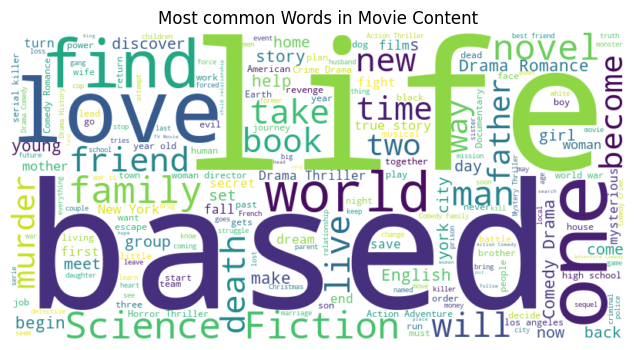

In [198]:
plt.figure(figsize=(10,4))
# "bilinear" --> is just a setting to make the letters look smoother and less pixelated.
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most common Words in Movie Content")
plt.show()

i will add some words to the STOPWORD list to make the data more accurate

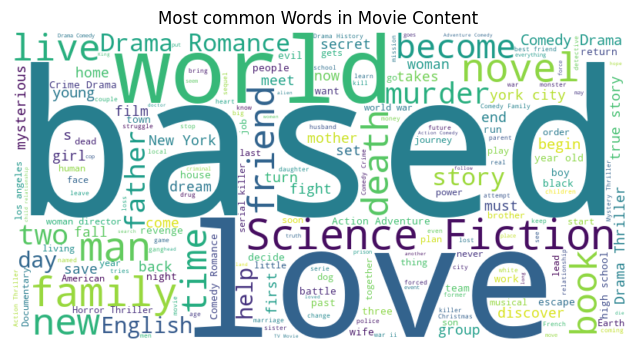

In [199]:
from wordcloud import STOPWORDS

my_stopwords =set(STOPWORDS)

my_stopwords.add("find")
my_stopwords.add("finds")
my_stopwords.add("one")
my_stopwords.add("way")
my_stopwords.add("will")
my_stopwords.add("take")
my_stopwords.add("make")
my_stopwords.add("life")
# my_stopwords.add("based")

wordcloud=WordCloud(width=800,height=400,background_color="white",stopwords=my_stopwords).generate(combined_text)

#plotting again
plt.figure(figsize=(10,4))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most common Words in Movie Content")
plt.show()

# nltk

In [200]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [201]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Youssef\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [202]:
from nltk.corpus import wordnet

def expand_with_synonyms(text):
    words = text.split()
    expanded_words = []

    for word in words:
        synonyms = set()

        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name().replace("_", " "))

        synonyms = list(synonyms)[:3]

        expanded_words.append(word)# Original word
        expanded_words.extend(synonyms)# Adding synonyms

    return " ".join(expanded_words)


In [203]:
stop_words=set(stopwords.words("english"))

In [204]:
def fixing_text(text):
    # here i will remove any speacial character or any number
    text=re.sub(r"^a-zA-Z\s","",text)
    text=text.lower()
    tokens=word_tokenize(text)
    tokens=[word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [205]:
df.loc[:,"Cleaned_Combined_weighted"]=df["combined_weighted_text"].apply(fixing_text)
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,tagline,genres,production_companies,production_countries,spoken_languages,keywords,release_date_categorized,Combined,combined_weighted_text,Cleaned_Combined_weighted
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",recent,Action Science Fiction Adventure Cobb a skille...,Action Science Fiction Adventure Action Scienc...,action science fiction adventure action scienc...
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",recent,Adventure Drama Science Fiction The adventures...,Adventure Drama Science Fiction Adventure Dram...,adventure drama science fiction adventure dram...
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",recent,Drama Action Crime Thriller Batman raises the ...,Drama Action Crime Thriller Drama Action Crime...,drama action crime thriller drama action crime...
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",recent,Action Adventure Fantasy Science Fiction In th...,Action Adventure Fantasy Science Fiction Actio...,action adventure fantasy science fiction actio...
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",recent,Science Fiction Action Adventure When an unexp...,Science Fiction Action Adventure Science Ficti...,science fiction action adventure science ficti...


In [206]:
df["Cleaned_Combined_weighted"]=df["Cleaned_Combined_weighted"].apply(expand_with_synonyms)

# TF-IDF (`Term Frequency-Inverse Document Frequency`)

In [207]:
# min_df --> ignore words that apears in fewer than 3 movies (as they maybe not that important or could also be a typo)
# max_df --> ignore words that appears in more than 90% of the movies (as they considered as a useless common words)
# max_features --> just remember the top 5000 important words
tf_idf=TfidfVectorizer(min_df=3,max_df=0.9,max_features=5000)

tf_idf_matrix=tf_idf.fit_transform(df["Cleaned_Combined_weighted"]) 

# Cosine Similarity

In [208]:
from sklearn.metrics.pairwise import linear_kernel
def normalize(text):
    return re.sub(r'[^a-z0-9]', '', text.lower())

def similarity_score(a, b):
    # Score = number of matching character sequences.
    score = 0
    for i in range(len(a)):
        for j in range(i+1, len(a)+1):
            sub = a[i:j]
            if re.search(sub, b):
                score += len(sub)  # longer matched substring = more score
    return score

def possible_titles(movie_name,data=df):
    norm_name = normalize(movie_name)
    scores = []
    for title, release_date in zip(data["title"], data["release_date"]):
        norm_title = normalize(title)
        if not norm_title:
            continue
        score = similarity_score(norm_name, norm_title)
        if score < len(norm_name) * 0.4:
            continue
        scores.append((title, score, release_date))
    scores.sort(key=lambda x: (x[1], -len(x[0])), reverse=True)
    top_matches = scores[:10]
    print("\nDid you mean:")
    for i, (title, score, date) in enumerate(top_matches, 1):
        print(f"{i}: {title} ({date})")
    try:
        selection = int(input("\nEnter the index (or 0 if none): "))
        if 1 <= selection <= len(top_matches):
            return top_matches[selection-1][0]
        return None
    except:
        return None

In [209]:
def recommendation_funtion(movie_name,data=df,top_n=5):
    idx = data[data["title"].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        print("ERROR: Movie not found.")
        return None
    idx = idx[0]
    
    # this will compute similarity for this ONE movie (1 x N)
    sim_scores = linear_kernel(tf_idf_matrix[idx:idx+1], tf_idf_matrix).flatten()
    # pair each movie with its score
    scores = list(enumerate(sim_scores))
    # sort descending by similarity
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[1:top_n+1]
    # sort based on popularity
    # scores = sorted(scores, key=lambda x: data.iloc[x[0]]["popularity"], reverse=True)

    movie_idxs = [i[0] for i in scores]

    # print(f"\nTop {top_n} recommendations for '{movie_name}':")
    return idx,movie_idxs

In [219]:
def create_round2_text(row):
    overview = str(row["overview"]) if pd.notna(row["overview"]) else ""
    genres = str(row["genres"]) if pd.notna(row["genres"]) else ""
    return (overview + " ") * 3 + (genres + " ") * 5
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["stage2_text"] = df.apply(create_round2_text, axis=1)
df["stage2_text"]=df["stage2_text"].apply(clean_text)
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,backdrop_path,budget,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,stage2_text
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,160000000,...,"Cobb, a skilled thief who commits corporate es...",83.952,https://image.tmdb.org/t/p/w500/oYuLEt3zVCKq57...,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",cobb a skilled thief who commits corporate esp...
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,165000000,...,The adventures of a group of explorers who mak...,140.241,https://image.tmdb.org/t/p/w500/gEU2QniE6E77NI...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",the adventures of a group of explorers who mak...
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,185000000,...,Batman raises the stakes in his war on crime. ...,130.643,https://image.tmdb.org/t/p/w500/qJ2tW6WMUDux91...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",batman raises the stakes in his war on crime w...
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,237000000,...,"In the 22nd century, a paraplegic Marine is di...",79.932,https://image.tmdb.org/t/p/w500/kyeqWdyUXW608q...,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",in the 22nd century a paraplegic marine is dis...
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,220000000,...,When an unexpected enemy emerges and threatens...,98.082,https://image.tmdb.org/t/p/w500/RYMX2wcKCBAr24...,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",when an unexpected enemy emerges and threatens...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15543,94196,Zarafa,6.838,101,Released,2012-01-25,12197574,78,/wu1ZfK910bxCUtyne1bL1s9lOLj.jpg,10750000,...,Inspired by the true story of the first giraff...,7.685,https://image.tmdb.org/t/p/w500/gsTt2bxvffCIsR...,,"Family, Animation","France 3 Cinéma, Prima Linéa Productions, Chao...","Belgium, France",French,"giraffe, sudan, based on true story, orphan, 1...",inspired by the true story of the first giraff...
15544,352695,Joshy,5.569,101,Released,2016-08-12,0,93,NaN,0,...,"After his engagement ends badly, Josh decides ...",5.185,https://image.tmdb.org/t/p/w500/qccbXBSGXopEmD...,Wedding's off. Party's on.,"Drama, Comedy","American Zoetrope, Destro Films, Bow + Arrow E...",United States of America,English,"male friendship, loss, board game, hot tub, bo...",after his engagement ends badly josh decides t...
15545,23928,Captain Horatio Hornblower,6.842,101,Released,1951-04-10,0,117,/79SaswBGk6lVbPgnGJQKC84NUyL.jpg,0,...,Captain Horatio Hornblower leads his ship HMS ...,9.043,https://image.tmdb.org/t/p/w500/oielnqLw4gVpaJ...,The sun never sets on his world of adventure.,"Adventure, War, History",Warner Bros. Pictures,United Kingdom,English,"captain, battle, napoleonic 

In [223]:
def stage2_rerank(main_idx, candidate_indices, df):

    indices = [main_idx] + candidate_indices
    texts = df.loc[indices, "stage2_text"].tolist()
    vectorizer = TfidfVectorizer(max_features=2000)
    mat = vectorizer.fit_transform(texts)
    sim = cosine_similarity(mat[0:1], mat).flatten()
    reranked = sorted(list(zip(indices[1:], sim[1:])),key=lambda x: x[1],reverse=True)
    return reranked

In [224]:
def final_recommendation(movie_name, df, top_n=5):
    main_idx, candidates = recommendation_funtion(movie_name, df, top_n)
    
    reranked = stage2_rerank(main_idx, candidates, df)
    print(f"\nFINAL RECOMMENDATIONS for {movie_name}:\n")
    for i, (idx, score) in enumerate(reranked, 1):
        print(f"{i}. {df.loc[idx,'title']}  (score={score:.3f})")


In [225]:
movie_name=input("Enter your favorite movie name: ")
movie_name=possible_titles(movie_name,df)
final_recommendation(movie_name,df,top_n=10)


Did you mean:
1: Tenet (2020-08-22)
2: Violet Evergarden: Eternity and the Auto Memory Doll (2019-09-06)
3: The Net (1995-07-28)
4: Tenebre (1982-10-28)
5: The Net (2016-10-06)
6: The Frighteners (1996-07-18)
7: A Perfect Enemy (2021-06-11)
8: Back of the Net (2019-04-11)
9: Casting JonBenet (2017-04-28)
10: The Night Listener (2006-02-12)

FINAL RECOMMENDATIONS for Tenet:

1. Predestination  (score=0.274)
2. The Rhythm Section  (score=0.210)
3. Double Team  (score=0.207)
4. Déjà Vu  (score=0.198)
5. London Has Fallen  (score=0.188)
6. November  (score=0.181)
7. Uri: The Surgical Strike  (score=0.169)
8. Mutant Action  (score=0.168)
9. Hotel Mumbai  (score=0.092)
10. Stratton  (score=0.090)


In [214]:
# --- Export artifacts for the server ---
import json
import numpy as np
import pickle
import os

# Replace these names with the variables in your notebook if different:
# - tf_idf is your TfidfVectorizer object
# - tf_idf_matrix is the matrix returned by tf_idf.fit_transform(...)
# - cosineSimilarity is the NxN similarity matrix computed earlier
# - df is your dataframe that contains Title and Cleaned_Combined columns

# Make output dir (put the outputs where your server will read them)
out_dir = "server_artifacts"
os.makedirs(out_dir, exist_ok=True)

# 1) Save titles
titles = df["title"].tolist()
with open(f"{out_dir}/titles.json", "w", encoding="utf-8") as f:
    json.dump(titles, f, ensure_ascii=False)

# 2) Save cleaned combined (optional but useful for debugging)
cleaned = df["Cleaned_Combined_weighted"].tolist()
with open(f"{out_dir}/cleaned.json", "w", encoding="utf-8") as f:
    json.dump(cleaned, f, ensure_ascii=False)

# 3) Save TF-IDF vocabulary (convert numpy types -> Python types)
vocab = tf_idf.vocabulary_

# Convert all keys and values into JSON-safe Python ints/strings
vocab_safe = {str(k): int(v) for k, v in vocab.items()}

with open(f"{out_dir}/vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab_safe, f, ensure_ascii=False)


# 4) Save TF-IDF matrix as dense numpy array (if large, consider sparse save)
# If the matrix is large and memory is a concern, you can save sparse with scipy.sparse.save_npz
try:
    from scipy import sparse
    sparse.save_npz(f"{out_dir}/tfidf_matrix.npz", tf_idf_matrix)
except Exception:
    np.save(f"{out_dir}/tfidf_matrix.npy", tf_idf_matrix.toarray())

# 5) Save the similarity matrix (cosineSimilarity computed in notebook)
# If you computed cosineSimilarity = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
# np.save(f"{out_dir}/similarity.npy", cosineSimilarity)

# 6) If you had helper functions or model metadata, pickle them (optional)
with open(f"{out_dir}/metadata.pkl", "wb") as f:
    pickle.dump({"num_movies": len(titles)}, f)

print("Exported artifacts to:", out_dir)


df=df.drop(columns=["release_date_categorized","combined_weighted_text","Combined","Cleaned_Combined_weighted","stage2_text"])
df.to_csv("cleaned_movies.csv",index=False)


Exported artifacts to: server_artifacts
